In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import time



In [2]:
# Put on GPU

device = torch.device ("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Extract images

noisy_imgs_1 , noisy_imgs_2 = torch.load('data/train_data.pkl')
noisy_imgs , clean_imgs = torch.load ('data/val_data.pkl')

noisy_imgs = noisy_imgs/255
clean_imgs = clean_imgs/255

print(noisy_imgs_1.size())


torch.Size([50000, 3, 32, 32])


In [4]:
# selct a preset of images:

imgs_1 = noisy_imgs_1[:10000]/255
imgs_2 = noisy_imgs_2[:10000]/255


In [56]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        """
        self.conv1 = nn.Conv2d(3, 10, kernel_size = 5, padding = (5 - 1) // 2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size = 5, padding = (5 - 1) // 2)
        self.convT1 = nn.ConvTranspose2d(10, 3, kernel_size = 5, padding = (5 - 1) // 2)
        """
        self.conv1 = nn.Conv2d(3, 10, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size = 4, stride = 2)
        self.convT1 = nn.ConvTranspose2d(10, 10, kernel_size = 4, stride = 2)
        self.convT2 = nn.ConvTranspose2d(10, 3, kernel_size = 5, stride = 1)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.dropout(F.relu(self.convT1(x)))
        x = F.sigmoid(self.convT2(x))

        return x

In [57]:
### For mini - project 1
class Model(nn.Module):
    
    def __init__(self):
    ## instantiate model + optimizer + loss function + any other stuff you need
        super().__init__()
        
        self.device = torch.device ("cuda" if torch.cuda.is_available() else "cpu")
        self.autoenc = Net().to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.autoenc.parameters(), lr = 1e-2)
        
        pass

    def load_pretrained_model(self):
    ## This loads the parameters saved in bestmodel .pth into the model
        self.autoenc  = model.load_state_dict(torch.load('bestmodel.pth'),strict=False)
        pass

    def train(self , train_input , train_target , mini_batch_size):
    #: train˙input : tensor of size (N, C, H, W) containing a noisy version of the images.

        train_input, train_target = train_input.to(self.device), train_target.to(self.device) # Use GPU
        
        nb_epochs = 20
        eta = 1e-1

        for epoch in range(nb_epochs):
            acc_loss = 0

            for b in range(0, train_input.size(0), mini_batch_size):
                output = self.autoenc(train_input.narrow(0, b, mini_batch_size))
                loss = self.criterion(output, train_target.narrow(0, b, mini_batch_size))
                acc_loss = acc_loss + loss.item()

                #self.autoenc.zero_grad()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                """
                with torch.no_grad():
                    for p in self.autoenc.parameters():
                        p -= eta * p.grad
                """
                        
            if not epoch % 5: 
                print(epoch, acc_loss)

    #: train˙target : tensor of size (N, C, H, W) containing another noisy version of the same images , which only differs from the input by their noise .
        pass

    def predict(self , test_input ):
    #: test˙input : tensor of size (N1 , C, H, W) that has to be denoised by the trained or the loaded network .
    #: returns a tensor of the size (N1 , C, H, W)
    
        torch.save(self.autoenc.state_dict(), 'bestmodel.pth')
        output = self.autoenc(test_input)
        
        return output
    
    # Add a method "load pretrained model" to load the best model


In [58]:
def psnr ( denoised , ground_truth ) :
        # Peak Signal to Noise Ratio : denoised and ground_truth have range [0 , 1]
        mse = torch.mean (( denoised - ground_truth ) ** 2)
        return -10 * torch.log10 ( mse + 10** -8)

In [59]:
mini_batch_size = 1000

model = Model()
print('ici')
model.train( imgs_1, imgs_2, mini_batch_size)

out = model.predict(noisy_imgs)

img_denoise_psnr = psnr(out ,clean_imgs )


print("psnr", img_denoise_psnr)


ici
0 0.6866068318486214
5 0.3797980770468712
10 0.3367033414542675
15 0.31753900088369846
psnr tensor(17.0409, grad_fn=<MulBackward0>)


torch.Size([3, 32, 32])


Text(0.5, 1.0, 'predict')

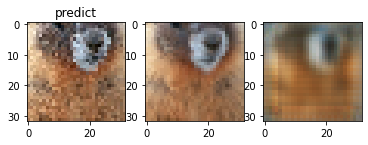

In [50]:
# AFFICHAGE
print(out[1].shape)
"""
#print(clean_imgs[1])
plt.imshow(clean_imgs[1].permute(1,2,0))
plt.show()
plt.imshow(out[1].permute(1,2,0).detach())
plt.show()
"""
fig, axs = plt.subplots(1,3)

axs[0].imshow(noisy_imgs[1].permute(1,2,0))
axs[0].set_title('noisy')
axs[1].imshow(clean_imgs[1].permute(1,2,0))
axs[0].set_title('clean')
axs[2].imshow(out[1].permute(1,2,0).detach())
axs[0].set_title('predict')



In [51]:
model_2 = Model()
model_2.load_pretrained_model()
out = model_2.predict(noisy_imgs)

TypeError: cannot assign 'torch.nn.modules.module._IncompatibleKeys' as child module 'autoenc' (torch.nn.Module or None expected)